<a href="https://colab.research.google.com/github/CLiz17/densenet-deepfake/blob/main/kaggle_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense,Activation
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from sklearn import metrics

fpath = "/content/drive/MyDrive/kaggle-dataset"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]

def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            resized_img = img_array.resize((150, 150))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

n = np.arange(images.shape[0])
np.random.seed(random_seed)
np.random.shuffle(n)

images = images[n]
labels = labels[n]

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.25
 )

train_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'training',
     class_mode = 'binary'
)

validation_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'validation',
    class_mode = 'binary',shuffle=False
)


dense_model = DenseNet121(input_shape=(150,150,3),include_top=False,weights="imagenet")

for layer in dense_model.layers:
    layer.trainable=False

model=Sequential()
model.add(dense_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

hist = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
)

model.save('kmodel.h5')

No. of images loaded =  2007 
No. of labels loaded =  2007
<class 'list'> <class 'list'>
Images shape =  (2007, 150, 150, 3) 
Labels shape =  (2007,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Found 1506 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
48/48 [==============================] - 260s 5s/step - loss: 0.2311 - accuracy: 0.9197 - val_loss: 0.4120 - val_accuracy: 0.9301
Epoch 2/10
48/48 [==============================] - 202s 4s/step - loss: 0.1652 - accuracy: 0.9509 - val_loss: 0.5057 - val_accuracy: 0.9122
Epoch 3/10
48/48 [==============================] - 249s 5s/step - loss: 0.1067 - accuracy: 0.9635 - val_loss: 0.2677 - val_accuracy: 0.9441
Epoch 4/10
48/48 [==============================] - 243s 5s/step - loss: 0.0975 - accuracy: 0.9668 - val_loss: 0.4010 - val_accuracy: 0.8982
Epoch 5/10
48/48 [==============================] - 245s 5s/step - loss: 0.0727 - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


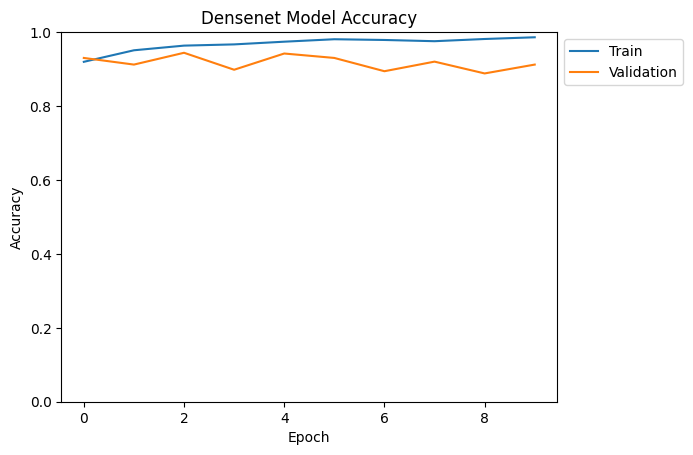

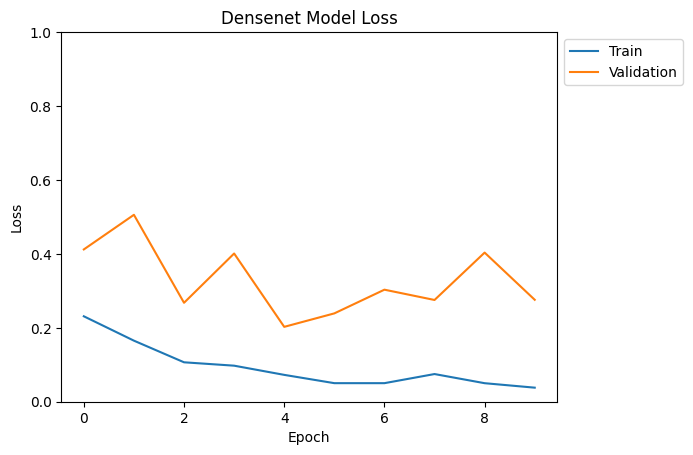

16/16 [==============================] - 44s 3s/step


<Axes: >

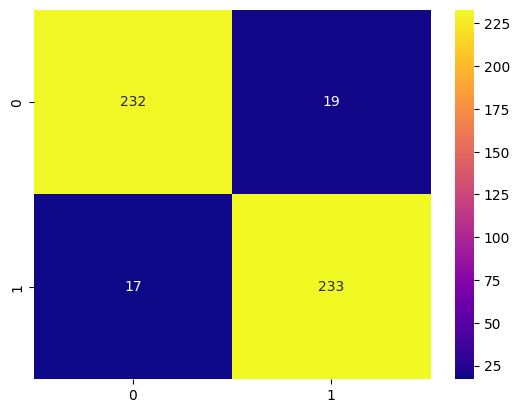

In [ ]:
# Graphs
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")
cm=confusion_matrix(y_true, y_pred)

sns.heatmap(cm,cmap="plasma",fmt="d",annot=True)

In [ ]:
# Calculations
def calculate_metrics(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = round(TP / (TP + FN), 3)
    specificity = round(TN / (TN + FP), 3)
    accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
    precision = round(TP / (TP + FP), 3)
    f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 3)

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

Sensitivity: 0.932
Specificity: 0.924
Accuracy: 0.928
Precision: 0.925
F1 Score: 0.928


1/1 [==============================] - 3s 3s/step


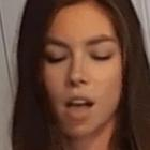

File: 122_18.jpg
The image is deepfake
1/1 [==============================] - 0s 120ms/step


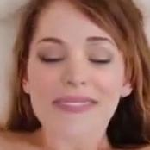

File: 164_54.jpg
The image is deepfake
1/1 [==============================] - 0s 136ms/step


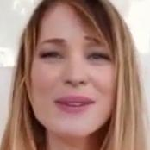

File: 163_150.jpg
The image is deepfake
1/1 [==============================] - 0s 118ms/step


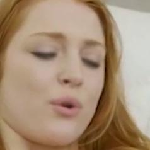

File: 158_366.jpg
The image is deepfake
1/1 [==============================] - 0s 117ms/step


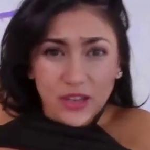

File: 173_33.jpg
The image is deepfake
1/1 [==============================] - 0s 116ms/step


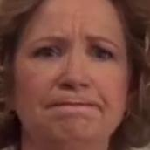

File: 88_40.jpg
The image is a real person
1/1 [==============================] - 0s 122ms/step


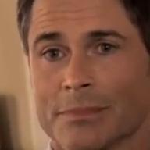

File: 64_130.jpg
The image is a real person
1/1 [==============================] - 0s 118ms/step


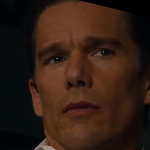

File: 56_60.jpg
The image is a real person
1/1 [==============================] - 0s 116ms/step


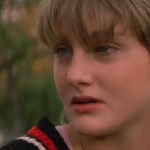

File: 63_87.jpg
The image is a real person
1/1 [==============================] - 0s 116ms/step


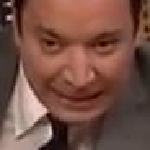

File: 37_300.jpg
The image is a real person


In [ ]:
# Testing -Training Dataset
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

model = load_model("/content/kmodel.h5")

def predict(file_path):
    img = load_img(file_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    result = "The image is deepfake" if prediction < 0.5 else "The image is a real person"
    return result, img

dataset_folder = "/content/drive/MyDrive/kaggle-dataset/df"

all_files = os.listdir(dataset_folder)

selected_files = random.sample(all_files, k=5)

for file_name in selected_files:
    file_path = os.path.join(dataset_folder, file_name)
    result, img = predict(file_path)
    display(img)
    print("File:", file_name)
    print(result)

dataset_folder = "/content/drive/MyDrive/kaggle-dataset/real"

all_files = os.listdir(dataset_folder)

selected_files = random.sample(all_files, k=5)

for file_name in selected_files:
    file_path = os.path.join(dataset_folder, file_name)
    result, img = predict(file_path)
    display(img)
    print("File:", file_name)
    print(result)

In [ ]:
# Testing - New Dataset
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

model = load_model("/content/kmodel.h5")

def predict(file_path):
    img = load_img(file_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    result = "The image is deepfake" if prediction < 0.5 else "The image is a real person"
    return result, img

dataset_folder = "/content/drive/MyDrive/test-dataset"

all_files = os.listdir(dataset_folder)

selected_files = random.sample(all_files, k=10)

for file_name in selected_files:
    file_path = os.path.join(dataset_folder, file_name)
    result, img = predict(file_path)
    display(img)
    print("File:", file_name)
    print(result)

OSError: No file or directory found at /content/kmodel.h5